In [2]:
%matplotlib notebook

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#import system as sys
from tqdm import tqdm_notebook as tqdm
#from matplotlib2tikz import save as tikz_save

## Basic functions

In [3]:
# Define linear neural network 
def DumbNet(u,w):
    # inputs
    u1 = u[0]
    u2 = u[1]
    # weights of y1
    w11 = w[0]
    w12 = w[1]
    w13 = w[2]
    # weights of y2
    w21 = w[3]
    w22 = w[4]
    w23 = w[5]
    ############
    # Compute output
    y1 = w11*u1 + w12*u2 + w13
    y2 = w21*u1 + w22*u2 + w23
    return np.array([y1,y2]).T

# Compute the value of the loss J
def Loss(x,u,yh,a,b,c,n):
    w = x[0:n]
    dw = x[n:2*n]
    J1 = np.array(yh-DumbNet(u,w))
    #print(J1)
    J = a*J1.dot(J1) + b*dw.dot(dw) + c*w.dot(w)
    return J

# Compute the gradient of the loss J
def Gradient(x,u,yh,a,b,c,n):
    # weights and their velocities
    w = x[0:n]
    dw = x[n:2*n]
    # inputs
    u1 = u[0]
    u2 = u[1]
    # ground truth (reference outputs)
    yh1 = yh[0]
    yh2 = yh[1]
    # weights of y1
    w11 = w[0]
    w12 = w[1]
    w13 = w[2]
    # weights of y2
    w21 = w[3]
    w22 = w[4]
    w23 = w[5]
    #############################################
    # Compute gradient of J
    y = DumbNet(u,w)
    dJ_w = 2.*a*np.array([u1*(y[0]-yh1),u2*(y[0]-yh1),y[0]-yh1,u1*(y[1]-yh2),u2*(y[1]-yh2),y[1]-yh2]).T
    #
    dJ_dw = np.array([2.*b*dw[0],2.*b*dw[1],2.*b*dw[2],2.*b*dw[3],2.*b*dw[4],2.*b*dw[5]]).T
    dJ = np.hstack((dJ_w,dJ_dw)).T
    # regularisation term
    dJr = np.array([2.*c*w11,2.*c*w12,2.*c*w13,2.*c*w21,2.*c*w22,2.*c*w23,0.,0.,0.,0.,0.,0.])
    #print(dJ,dJr)
    return dJ+dJr

# Define the PH model (ODE)
def HamiltonianModel(x,t,u,yh,beta,a,b,c,n):
    # define the matrix F
    On = np.zeros((n,n))
    In = np.eye(n)
    B = np.array(beta*np.eye(n))
    #F = np.vstack((np.hstack((On,In/b)),np.hstack((-In,-B))))
    # Compute the gradient
    dJ = Gradient(x,u,yh,a,b,c,n)
    # Compute derivative
    #dxdt = F.dot(dJ)
    dwdt = dJ[n:2*n]/b
    ddwdt = -dJ[0:n] - beta*dJ[n:2*n]/b
    dxdt = np.hstack((dwdt,ddwdt))
    return dxdt

## Batch Training functions

In [4]:
def LossBatch(bs,x,U,Yh,a,b,c,n):
    J_tot = 0
    for i in range(bs):
        #print(i)
        u = U[i]
        yh = Yh[i]
        #print(u,yh)
        J_tot = J_tot + Loss(x,u,yh,a,b,c,n)
    # print(dJ_tot[0]/bs)
    return J_tot/bs

def GradientBatch(bs,x,U,Yh,a,b,c,n):
    dJ_tot = np.zeros((1,2*n))
    dJ_tot = dJ_tot[0] 
    for i in range(bs):
        #print(i)
        u = U[i]
        yh = Yh[i]
        #print(u,yh)
        dJ_tot = dJ_tot + Gradient(x,u,yh,a,b,c,n)
        #print(Gradient(x,u,yh,a,b,c,n))
    return dJ_tot/bs 

def HamModBatch(x,t,bs,U,Yh,beta,a,b,c,n):
    # define the matrix F
    On = np.zeros((n,n))
    In = np.eye(n)
    B = np.array(beta*np.eye(n))
    F = np.vstack((np.hstack((On,In)),np.hstack((-In,-B))))
    # Compute the gradient
    dJ = GradientBatch(bs,x,U,Yh,a,b,c,n)
    #print(dJ)
    # Compute derivative
    dxdt = F.dot(dJ)
    return dxdt

# Create Dataset

In [5]:
from scipy.integrate import odeint

In [6]:
# Define Linear ODE (damped linear oscillator)
K = 1   # spring const.
B = 0.1 # damping coeff.
def lin_sys(x,t):
    dxdt = [x[1],-K*x[0]-B*x[1]]
    return  dxdt

<IPython.core.display.Javascript object>


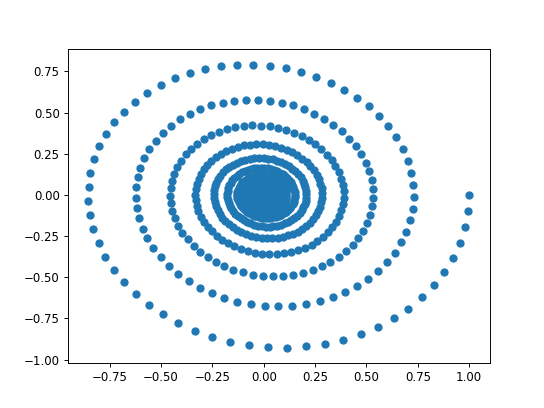

In [7]:
# Integrate the linear system
Ti = 0   # Initial time
Tf = 100 # Finital time
Ns = 1000 # Number of samples
t = np.linspace(Ti,Tf,Ns).tolist()
x0 = [1,0] # Initial condition

# Integrate ODE
x = odeint(lin_sys,x0,t)

# Plot phase-space trajectory
plt.figure()
plt.scatter(x[:,0],x[:,1])

#### Compute & plot corresponding vector field

<IPython.core.display.Javascript object>


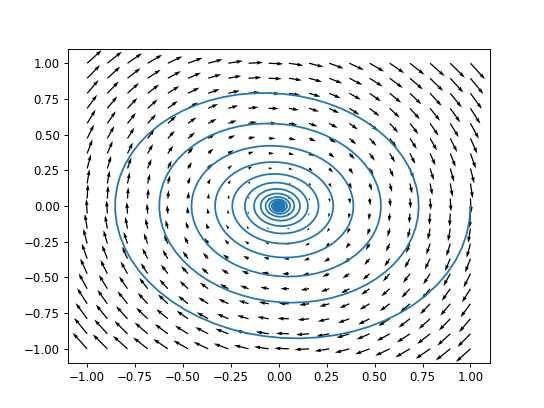

In [8]:
Np = 20
x1 = np.linspace(-1,1,Np)
x2 = np.linspace(-1,1,Np)
X1,X2 = np.meshgrid(x1,x2)

U = np.zeros((Np,Np))
V = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        U[i,j] = X2[i,j]
        V[i,j] = -K*X1[i,j] - B*X2[i,j]

fig, ax = plt.subplots()
q = ax.quiver(X1, X2, U, V)
ax.plot(x[:,0],x[:,1])

### Create training dataset

In [9]:
N = len(x)
X = x               # inputs
y = np.zeros((N,2)) # labels
for i in range(N):
    y[i,0] = x[i,1]
    y[i,1] = -K*x[i,0] - B*x[i,1]

### Train on a batch of arbitrary lenght

In [10]:
N_tot = len(X)
bs = N_tot
N_batch = int(N_tot/bs)
Ub = X.reshape(N_batch,bs,2)
Yhb = y.reshape(N_batch,bs,2)

t = np.linspace(0, 60, 6000)
beta = 0.5
a = 1.
b = 1.
c = 0.00
n = 6

# Initialise variable where to store results
xf = np.array([[1,1,1,1,1,1,1,1,1,1,1,1],np.random.randn(1,2*n)[0].tolist()], dtype='float')
tf = np.array([0.])
J = np.array([0.])
for i in tqdm(range(N_batch)):
    U = Ub[i]
    Yh = Yhb[i]
    x0 = xf[-1] 
    #print(x0)
    sol = odeint(HamModBatch, x0, t, args=(bs,U,Yh,beta,a,b,c,n))
    xf = np.vstack((xf,sol))
    tf = np.hstack((tf,t+tf[-1]))
    N = len(sol)
    Ji = np.zeros((N,1))
    for i in range(N):
        Ji[i] = LossBatch(bs,sol[i],U,Yh,a,b,c,n)
    J = np.vstack((J,Ji))
xf = xf[2:]
J = J[1:]
tf = tf[1:]

#### Plot parameters trajectory & Loss

<IPython.core.display.Javascript object>


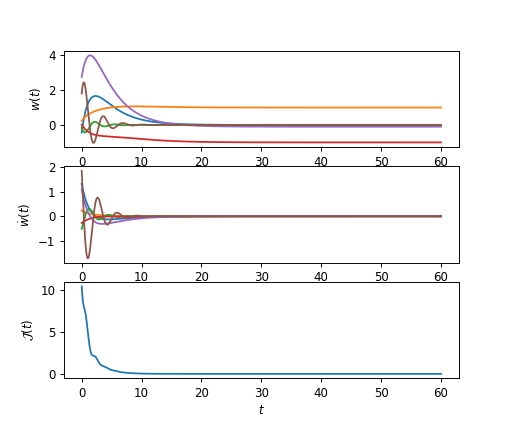

Text(0, 0.5, '$\\mathcal{J}(t)$')

In [11]:
plt.figure(figsize=(6,5))
plt.subplot(311)
plt.plot(tf,xf[:,:n]);
plt.xlabel("$t$")
plt.ylabel("$w(t)$")
plt.subplot(312)
plt.plot(tf,xf[:,n:2*n]);
plt.xlabel("$t$")
plt.ylabel("$\dot{w}(t)$")
plt.subplot(313)
plt.plot(tf,J);
plt.xlabel("$t$")
plt.ylabel("$\mathcal{J}(t)$")
#plt.savefig('weights.eps', format='eps', dpi=300)

### Compute reconstructed vector field & reconstruction error

given the linear system:
\begin{equation}
    \dot{x} = Ax
\end{equation}
Let the neural network model be
\begin{equation}
    y = f(x,\vartheta)
\end{equation}
After the training, the reconstruction error is computed (in a certain quantized region of the state-space) as
\begin{equation}
    E(x) = \|Ax-f(x,\vartheta^*)\|_2^2
\end{equation}
where $\vartheta^*$ is the trained vector of parameters

In [12]:
U = np.zeros((Np,Np))
V = np.zeros((Np,Np))
Uest = np.zeros((Np,Np))
Vest = np.zeros((Np,Np))
E = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        u = [X1[i,j],X2[i,j]]
        y_ij = DumbNet(u,sol[-1])
        U[i,j] = X2[i,j]
        V[i,j] = -K*X1[i,j] - B*X2[i,j]
        Uest[i,j] = y_ij[0]
        Vest[i,j] = y_ij[1]
        E[i,j] = np.sqrt(pow(U[i,j]-Uest[i,j],2)+pow(V[i,j]-Vest[i,j],2))

<IPython.core.display.Javascript object>


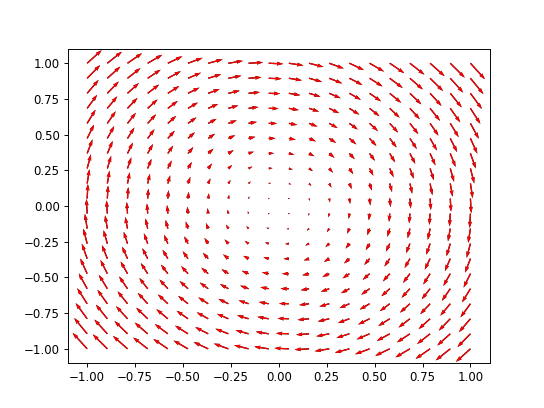

In [13]:
#### Plot ground truth VS learned
fig, ax = plt.subplots()
q = ax.quiver(X1, X2, U, V)
q_est = ax.quiver(X1, X2, Uest, Vest, color = 'r')

<IPython.core.display.Javascript object>


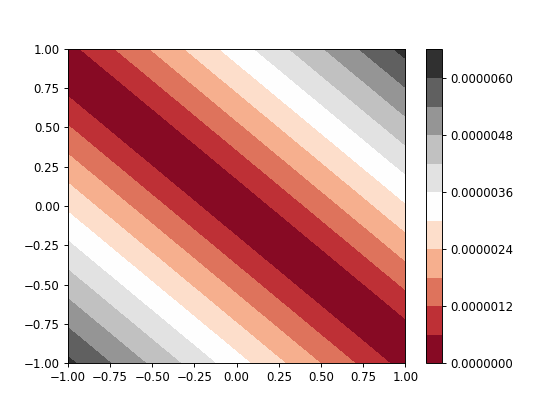

In [14]:
#### Plot contour map of the vector field's reconstruction error
plt.figure()
plt.contourf(X1, X2, E,10,cmap='RdGy')
plt.colorbar();

### Test performance on trajectory following 
We want to compare the reference trajectory $x_{r}(t)$ obtained by integrating the ODE $\dot{x}=Ax$ with $x_r(0) = x_0$ with a trajectory $\hat{x}(t)$ obtained by integrating $\dot{x}= f(x,\theta^*)$ (the NN model) with the same initial condition.

We can then evaluate how the reconstructed trajectory remains close to $x_r(t)$

In [18]:
# define the reconstructed ODE
w = xf[-1]
print(w[0:n],[0,1,-K,-B])
def dumb_sys(x,t):
    return DumbNet(x,w)

[ 1.55742049e-06  1.00000171e+00  1.67800942e-08 -9.99998206e-01
 -9.99980017e-02  1.81151964e-08] [0, 1, -1, -0.1]


In [19]:
t = np.linspace(0,100,1000).tolist()
x0 = [1,0] # Initial condition

# Integrate ODE
xh = odeint(dumb_sys,x0,t)

<IPython.core.display.Javascript object>


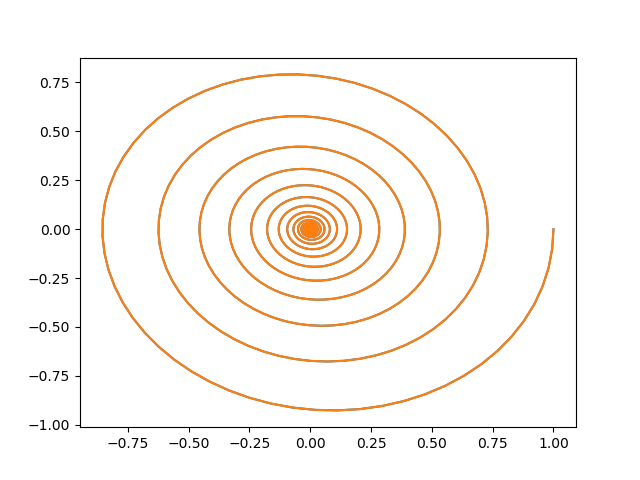

In [20]:
plt.figure()
plt.plot(x[:,0],x[:,1])
plt.plot(xh[:,0],xh[:,1])

<IPython.core.display.Javascript object>


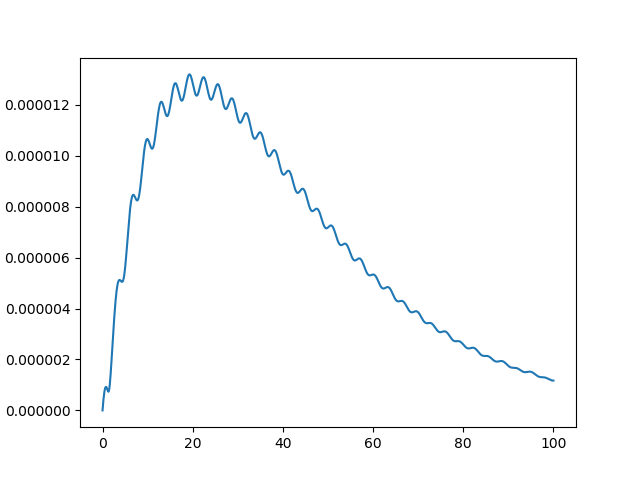

In [23]:
# compute error over time
e = np.zeros((len(x),1))
for i in range(len(x)):
    e[i] = np.linalg.norm(x[i]-xh[i])

plt.figure()
plt.plot(t,e)